In [1]:
#model trainings are differernt in the two notebooks
import pandas as pd
import scanpy as sc
import anndata as ad
import os
import numpy as np
import scvi

In [2]:
data_dir = '/home/jing/Phd_project/project_UCD_blca/blca_DATA/blca_DATA_GSE135337/'
os.chdir(data_dir)

In [3]:
names_list = ["GSM4006644_BC1", "GSM4006647_BC4" ,"GSM4006648_BC5", "GSM4751267_BC6" ,"GSM4751268_BC7"]

GSM4006644_BC1


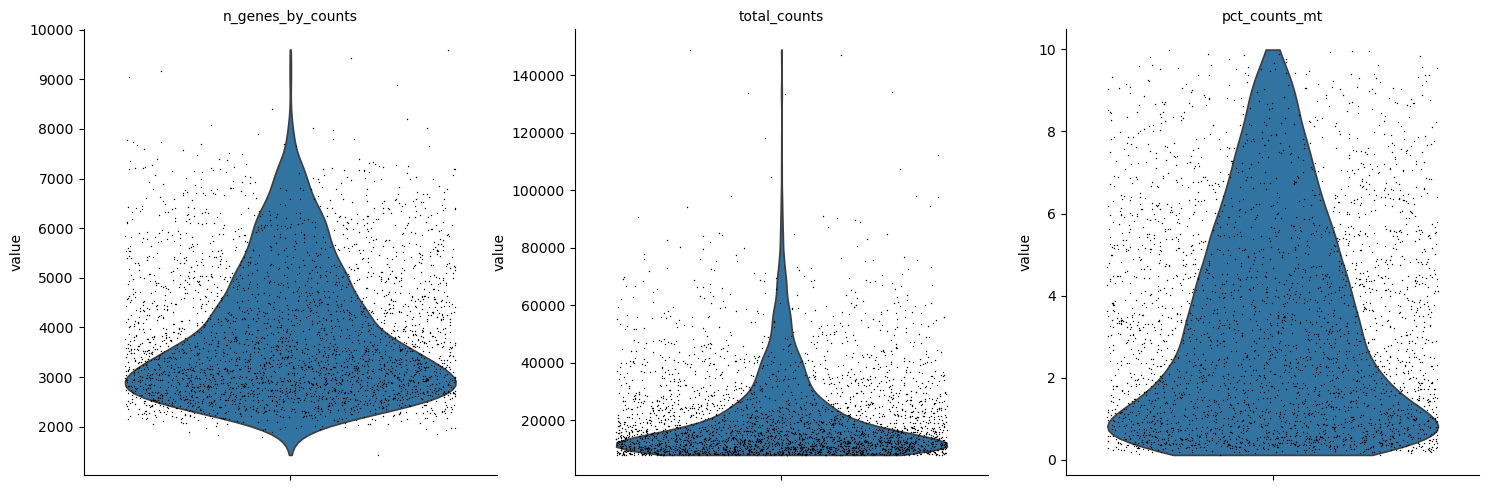

/tmp/ipykernel_1386536/3980296812.py:35: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['source'] = name


GSM4006647_BC4


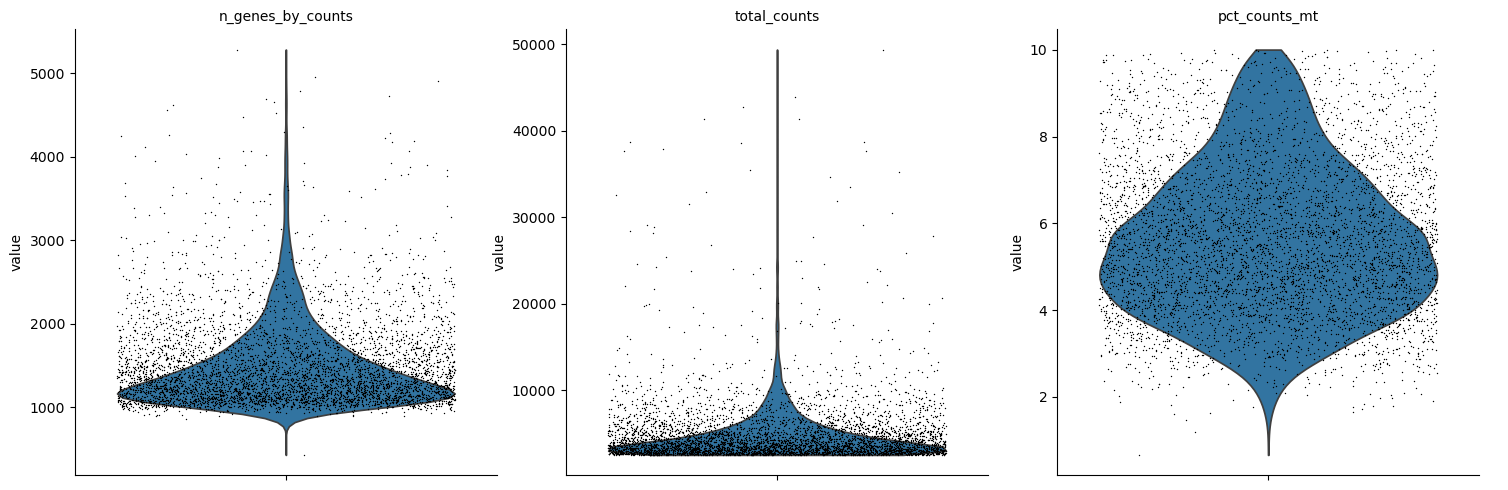

/tmp/ipykernel_1386536/3980296812.py:35: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['source'] = name


GSM4006648_BC5


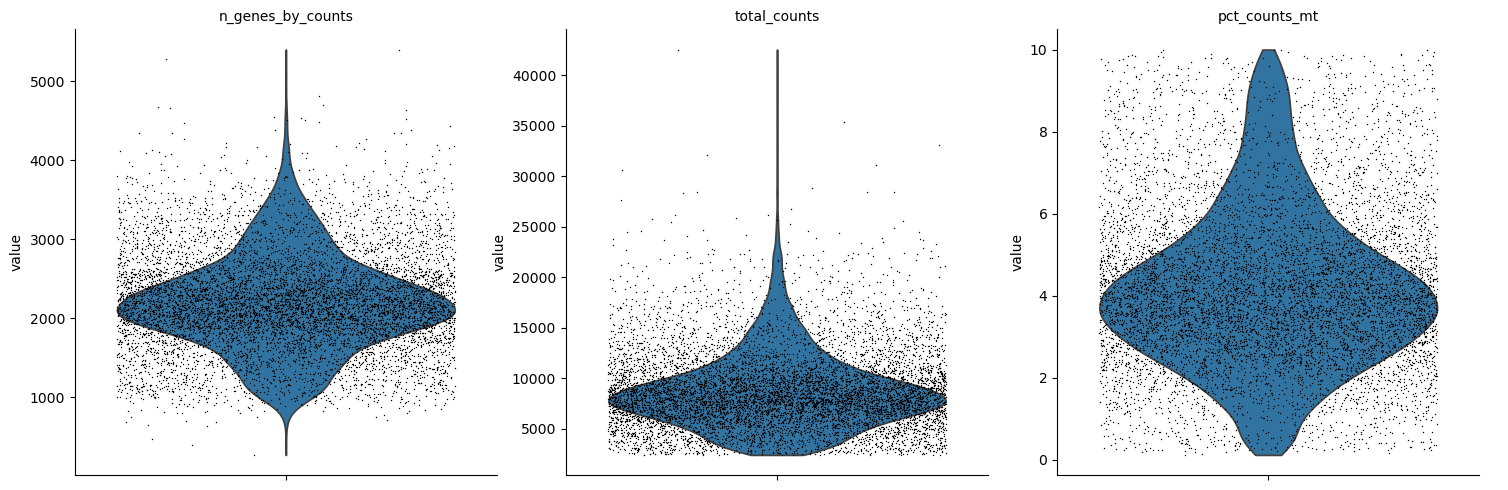

/tmp/ipykernel_1386536/3980296812.py:35: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['source'] = name


GSM4751267_BC6


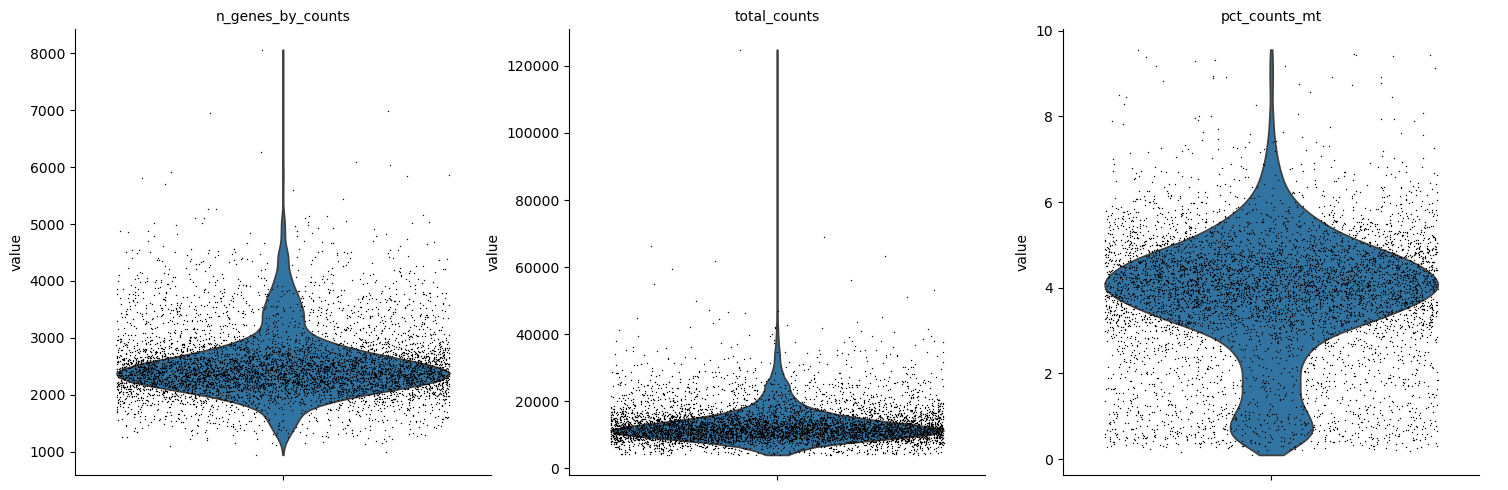

/tmp/ipykernel_1386536/3980296812.py:35: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['source'] = name


GSM4751268_BC7


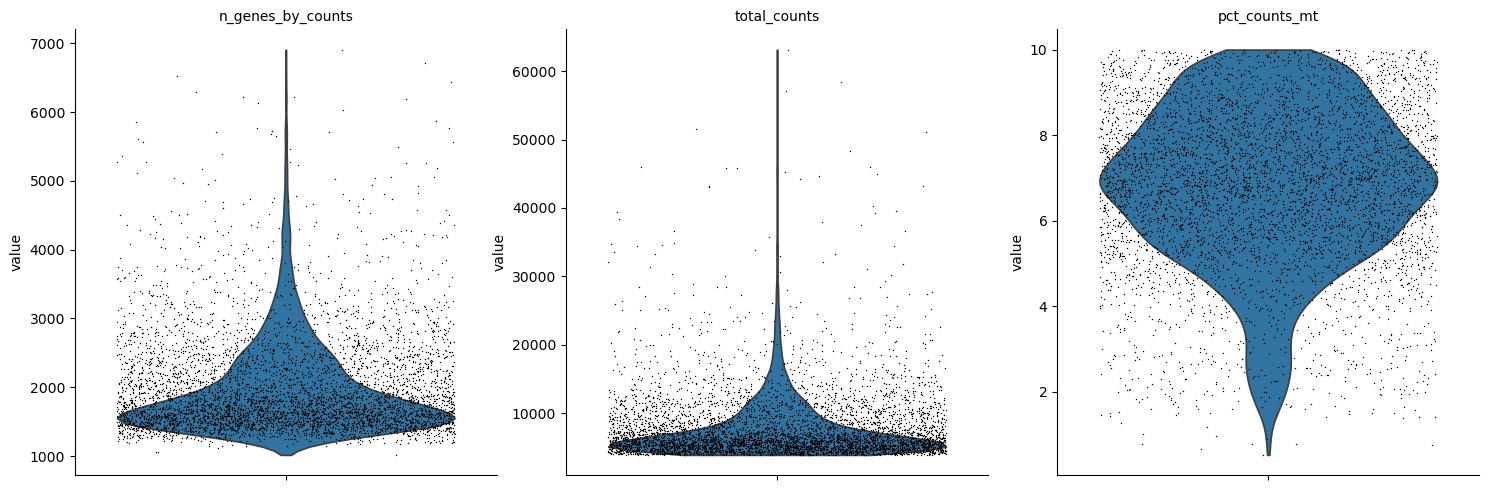

/tmp/ipykernel_1386536/3980296812.py:35: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['source'] = name


In [4]:
adata_list = []

# Loop over each sample and read in the AnnData object
for name in names_list:
    file_path = f"{name}_gene_cell_exprs_table.txt.gz"
    df = pd.read_csv(file_path, sep='\t')
    df.index = df.iloc[:, 0]
    gene_symbols = df.iloc[:,:2]

    # Drop the first two columns (Ensembl ID and gene name)
    df = df.iloc[:, 2:]
    # Transpose so that cells are rows and genes are columns
    df = df.T

    adata = ad.AnnData(df)

    adata.obs['CellID']= df.index
    adata.var[['Ensemble_ID','Gene']]= gene_symbols
    adata.var.index= adata.var['Gene']
    adata.var_names_make_unique() 
    adata.var['mt'] =adata.var_names.str.startswith('MT-')

    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.calculate_qc_metrics(adata,qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    print(name)
    sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True)
    
    adata= adata[adata.obs.n_genes_by_counts <6001, :]
    #adata= adata[adata.obs.pct_counts_mt< 5, :].copy()

    adata.obs['source'] = name
    adata.layers["counts"] = adata.X.copy()    

    adata_list.append(adata)
    

In [5]:
batch_names = [adata.obs['source'].iloc[0] for adata in adata_list]
adata = adata_list[0].concatenate(adata_list[1:], batch_key='source', batch_categories=batch_names)                                  

/tmp/ipykernel_1386536/1379501109.py:2: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata_list[0].concatenate(adata_list[1:], batch_key='source', batch_categories=batch_names)


In [6]:
immune_remove = pd.read_pickle('/home/jing/Phd_project/project_UCD_blca/blca_publication_OUTPUT/immune_cells_obs.pkl')

In [7]:
adata_non_immune = adata[~adata.obs.index.isin(immune_remove.index),]
adata_non_immune


View of AnnData object with n_obs × n_vars = 27864 × 13656
    obs: 'CellID', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'source'
    var: 'mt', 'Ensemble_ID-GSM4006644_BC1', 'Gene-GSM4006644_BC1', 'n_cells_by_counts-GSM4006644_BC1', 'mean_counts-GSM4006644_BC1', 'pct_dropout_by_counts-GSM4006644_BC1', 'total_counts-GSM4006644_BC1', 'Ensemble_ID-GSM4006647_BC4', 'Gene-GSM4006647_BC4', 'n_cells_by_counts-GSM4006647_BC4', 'mean_counts-GSM4006647_BC4', 'pct_dropout_by_counts-GSM4006647_BC4', 'total_counts-GSM4006647_BC4', 'Ensemble_ID-GSM4006648_BC5', 'Gene-GSM4006648_BC5', 'n_cells_by_counts-GSM4006648_BC5', 'mean_counts-GSM4006648_BC5', 'pct_dropout_by_counts-GSM4006648_BC5', 'total_counts-GSM4006648_BC5', 'Ensemble_ID-GSM4751267_BC6', 'Gene-GSM4751267_BC6', 'n_cells_by_counts-GSM4751267_BC6', 'mean_counts-GSM4751267_BC6', 'pct_dropout_by_counts-GSM4751267_BC6', 'total_counts-GSM4751267_BC6', 'Ensemble_ID-GSM4751268_BC7', 'Gene-GSM4751268_BC7', '

In [8]:
scvi.data.poisson_gene_selection(adata_non_immune)
adata_non_immune.var.head() #raw counts needed

/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/jing/miniforge3/envs/cstar/lib/python3.12/site ...


Sampling from binomial...:   0%|          | 0/10000 [00:00<?, ?it/s]

/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/scvi/data/_preprocessing.py:213: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": "poisson_zeros"}


,mt,Ensemble_ID-GSM4006644_BC1,Gene-GSM4006644_BC1,n_cells_by_counts-GSM4006644_BC1,mean_counts-GSM4006644_BC1,pct_dropout_by_counts-GSM4006644_BC1,total_counts-GSM4006644_BC1,Ensemble_ID-GSM4006647_BC4,Gene-GSM4006647_BC4,n_cells_by_counts-GSM4006647_BC4,...,n_cells_by_counts-GSM4751268_BC7,mean_counts-GSM4751268_BC7,pct_dropout_by_counts-GSM4751268_BC7,total_counts-GSM4751268_BC7,highly_variable,observed_fraction_zeros,expected_fraction_zeros,prob_zero_enriched_nbatches,prob_zero_enrichment,prob_zero_enrichment_rank
Gene,,,,,,,,,,,,,,,,,,,,,
TSPAN6,False,ENSG00000000003,TSPAN6,2473,3.086700,23.151025,9933,ENSG00000000003,TSPAN6,1048,...,2339,0.638059,57.649828,3524,True,0.578955,0.516304,1,0.2840,13352.0
DPM1,False,ENSG00000000419,DPM1,1554,0.872281,51.709136,2807,ENSG00000000419,DPM1,1788,...,2075,0.488503,62.429839,2698,True,0.547804,0.555711,1,0.2411,12377.0
SCYL3,False,ENSG00000000457,SCYL3,365,0.123990,88.657551,399,ENSG00000000457,SCYL3,162,...,193,0.035850,96.505522,198,False,0.959266,0.958998,0,0.0399,4609.0
C1orf112,False,ENSG00000000460,C1orf112,146,0.050031,95.463021,161,ENSG00000000460,C1orf112,80,...,58,0.010502,98.949846,58,False,0.983491,0.983193,0,0.0172,2447.0
FGR,False,ENSG00000000938,FGR,781,0.302051,75.730267,972,ENSG00000000938,FGR,18,...,118,0.022452,97.863480,124,False,0.955103,0.951467,0,0.0487,5275.0


In [9]:
adata_non_immune.var[adata_non_immune.var["highly_variable"]== True].index

Index(['TSPAN6', 'DPM1', 'CFH', 'FUCA2', 'GCLC', 'KRIT1', 'BAD', 'LAP3',
       'CD99', 'HS3ST1',
       ...
       'CH17-360D5.2', 'PCGF2', 'PSMB3', 'CISD3', 'DDX52', 'GGNBP2', 'MRPL45',
       'FO538757.2', 'AC090498.1', 'LLNLR-245B6.1'],
      dtype='object', name='Gene', length=4000)

In [10]:
wkdir= "/home/jing/Phd_project/project_UCD_blca/blca_publication_OUTPUT/blca_publication_OUTPUT_LINCS/"
data_year = "2020"
cell_name = "BC3C"

data_dir = os.path.join(wkdir,"00_outputs_" + data_year + "_" + cell_name)
data_file = os.path.join(data_dir, "Data_norm_" + data_year + "_" + cell_name+ ".xlsx")
Data_norm = pd.read_excel(data_file, index_col = 0)
display(Data_norm)

genes_list = Data_norm.columns.to_list()
print("Landmark genes in LINCS data:", len(genes_list), genes_list)


,AARS,ABCB6,ABCC5,ABCF1,ABCF3,ABHD4,ABHD6,ABL1,ACAA1,ACAT2,...,ZMIZ1,ZMYM2,ZNF131,ZNF274,ZNF318,ZNF395,ZNF451,ZNF586,ZNF589,ZW10
ASG002_BC3C_24H:A03,-0.191254,-0.055246,0.039596,-0.256266,-0.040419,-0.590523,-0.159396,-0.074319,0.457981,0.409608,...,0.543203,0.494266,-0.011923,-0.225931,0.285054,-0.775246,0.166031,-0.024873,0.238723,0.284204
ASG002_BC3C_24H:A04,-0.265754,-0.317496,0.118696,-0.136665,-0.301569,-0.403023,0.124804,-0.036470,0.311931,0.660457,...,-0.565096,-0.088634,0.122977,-0.047931,0.141804,0.129054,-0.028819,-0.028773,-0.253627,-0.752646
ASG002_BC3C_24H:A05,-0.181954,-0.081597,-0.210304,1.559535,-0.019019,-0.457423,0.071404,0.074080,-0.356119,0.498808,...,0.226104,-0.228034,-0.121023,-0.075331,-0.133146,0.355054,0.022831,-0.084073,0.283123,-0.894896
ASG002_BC3C_24H:A06,0.033446,0.042404,-0.150154,-0.093165,0.053180,-0.053823,0.087704,0.167681,-0.601569,0.383308,...,-0.608596,-0.228835,0.072777,0.082970,-0.570996,2.847754,-0.211670,-0.067273,0.081723,0.338704
ASG002_BC3C_24H:J13,0.204446,0.180704,0.089096,-0.054666,0.053381,0.044877,-0.277396,-0.157419,0.535681,-3.933493,...,-0.318397,0.122265,-0.134323,-0.088931,-0.067996,-0.515847,-0.005069,0.067527,0.002223,0.204904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MOAR012_BC3C_24H:P20,0.647151,0.211700,-0.979200,0.597350,-0.375751,0.388300,0.394524,0.120151,-0.166775,-1.129125,...,-1.598475,-0.552750,0.515151,0.120800,0.082675,0.529700,0.383225,-0.207225,2.268450,-1.248500
MOAR012_BC3C_24H:P21,0.171800,0.046300,-0.145550,-0.295150,0.030849,0.420951,0.222075,0.179800,0.274724,-0.423975,...,-1.650575,0.203600,-0.003250,-0.064800,-0.037675,0.076499,0.201825,0.416875,0.287450,-0.971700
MOAR012_BC3C_24H:P22,0.648700,0.058749,-0.031700,0.408249,-0.753950,0.332200,-0.357525,-0.107650,-0.213575,0.074225,...,0.127625,0.031600,0.103250,-0.249600,0.046375,1.486200,0.440325,0.090075,-0.031650,-0.944300
MOAR012_BC3C_24H:P23,0.090499,-0.469300,-0.611800,0.873550,-0.788450,-0.097199,-0.366575,-0.490600,-0.624675,-0.009275,...,0.054676,-0.596050,0.084600,0.444700,0.431375,-0.921501,0.044926,0.716076,-0.000900,-1.106700


Landmark genes in LINCS data: 978 ['AARS', 'ABCB6', 'ABCC5', 'ABCF1', 'ABCF3', 'ABHD4', 'ABHD6', 'ABL1', 'ACAA1', 'ACAT2', 'ACBD3', 'ACD', 'ACLY', 'ACOT9', 'ADAM10', 'ADAT1', 'ADGRE5', 'ADGRG1', 'ADH5', 'ADI1', 'ADO', 'ADRB2', 'AGL', 'AKAP8', 'AKAP8L', 'AKR7A2', 'AKT1', 'ALAS1', 'ALDH7A1', 'ALDOA', 'ALDOC', 'AMDHD2', 'ANKRD10', 'ANO10', 'ANXA7', 'APBB2', 'APOE', 'APP', 'APPBP2', 'ARFIP2', 'ARHGAP1', 'ARHGEF12', 'ARHGEF2', 'ARID4B', 'ARID5B', 'ARL4C', 'ARNT2', 'ARPP19', 'ASAH1', 'ASCC3', 'ATF1', 'ATF5', 'ATF6', 'ATG3', 'ATMIN', 'ATP11B', 'ATP1B1', 'ATP2C1', 'ATP6V0B', 'ATP6V1D', 'AURKA', 'AURKB', 'AXIN1', 'B4GAT1', 'BACE2', 'BAD', 'BAG3', 'BAMBI', 'BAX', 'BCL2', 'BCL7B', 'BDH1', 'BECN1', 'BHLHE40', 'BID', 'BIRC2', 'BIRC5', 'BLCAP', 'BLMH', 'BLVRA', 'BMP4', 'BNIP3', 'BNIP3L', 'BPHL', 'BRCA1', 'BTK', 'BUB1B', 'BZW2', 'C2CD2', 'C2CD2L', 'C2CD5', 'C5', 'CAB39', 'CALM3', 'CALU', 'CAMSAP2', 'CANT1', 'CAPN1', 'CARMIL1', 'CASC3', 'CASK', 'CASP10', 'CASP2', 'CASP3', 'CASP7', 'CAST', 'CAT', 'CBLB

In [11]:
adata_non_immune.var[adata_non_immune.var["highly_variable"]== True].index.intersection(genes_list)

Index(['TSPAN6', 'BAD', 'LAP3', 'CFLAR', 'FKBP4', 'RBM6', 'MYCBP2', 'RALA',
       'PAF1', 'PAFAH1B1',
       ...
       'MLLT11', 'VDAC1', 'CSNK1E', 'MYCBP', 'FIS1', 'CEBPD', 'CEBPA', 'TWF2',
       'CHMP4A', 'MRPL12'],
      dtype='object', name='Gene', length=438)

In [12]:
from scipy import sparse
adata_non_immune = adata_non_immune[:, adata_non_immune.var["highly_variable"]]  # focus on selected genes
adata_non_immune.layers["counts"]  = sparse.csr_matrix(adata_non_immune.X)
scvi.model.SCVI.setup_anndata(adata_non_immune, layer="counts", batch_key="source")  # prepare data for scVI

/tmp/ipykernel_1386536/1071881595.py:3: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata_non_immune.layers["counts"]  = sparse.csr_matrix(adata_non_immune.X)


In [13]:
model = scvi.model.SCVI(
    adata_non_immune, gene_likelihood="nb"
)  # We use Negative Binomial count likelihoods, following Boyeau et al., 2023.
model.train(
    check_val_every_n_epoch=1,
    max_epochs=400,
    early_stopping=True,
    early_stopping_patience=20,
    early_stopping_monitor="elbo_validation",
)

/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/jing/miniforge3/envs/cstar/lib/python3.12/site ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/jing/miniforge3/envs/cstar/lib/python3.12/site ...
/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bo

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


<Axes: xlabel='epoch'>

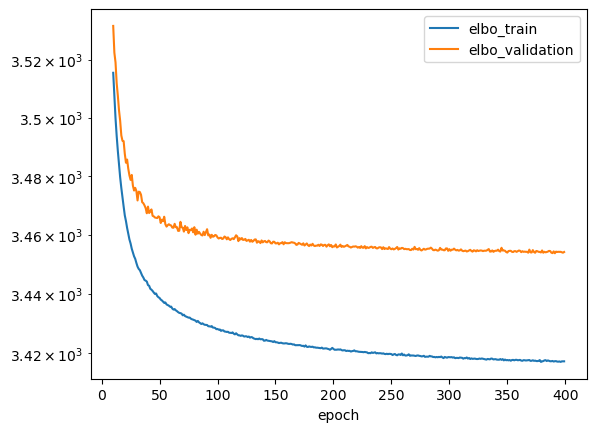

In [14]:
# Ensure convergence
train_test_results = model.history["elbo_train"]
train_test_results["elbo_validation"] = model.history["elbo_validation"]
train_test_results.iloc[10:].plot(logy=True)  # exclude first 10 epochs
#plt.show()

In [15]:
SCVI_LATENT_KEY = "X_scVI"

latent = model.get_latent_representation()
adata_non_immune.obsm[SCVI_LATENT_KEY] = latent
sc.pp.neighbors(adata_non_immune, use_rep=SCVI_LATENT_KEY)

/tmp/ipykernel_1386536/3936018484.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_non_immune,resolution=0.5)


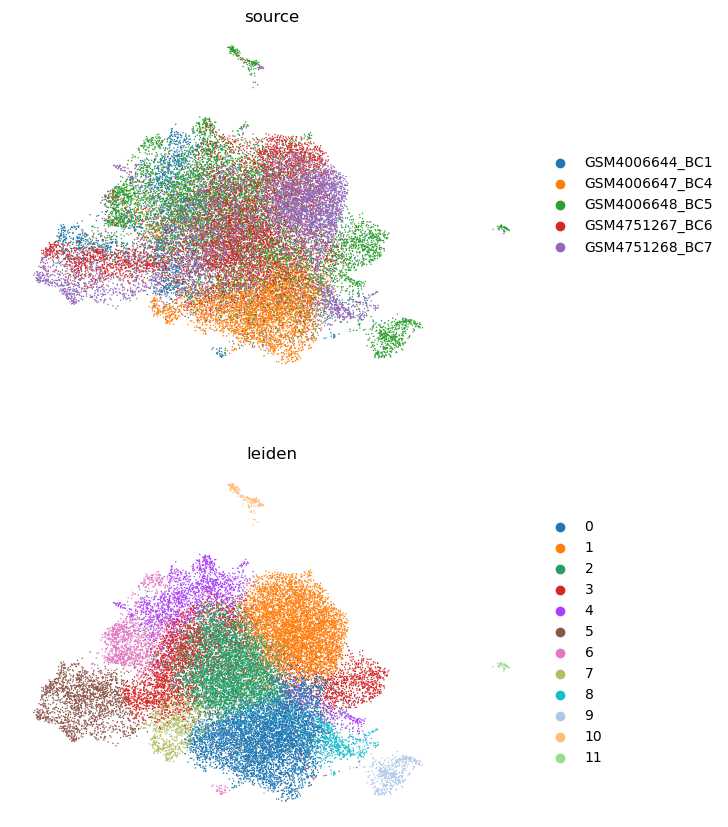

In [16]:
sc.tl.leiden(adata_non_immune,resolution=0.5)
sc.tl.umap(adata_non_immune)#, min_dist=0.3)
sc.pl.umap(
    adata_non_immune,
    color=["source", "leiden"],
    frameon=False,
    ncols=1,
)

In [17]:
obs= pd.read_csv('/home/jing/Phd_project/project_UCD_blca/blca_publication_OUTPUT/blca_publication_OUTPUT_svm/blca_scR_non_immune_obs.xlsx',index_col=0)

In [18]:
obs

,CellID,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,source,_scvi_batch,_scvi_labels,leiden
AAACCTGAGAAGAAGC.1-GSM4006644_BC1,AAACCTGAGAAGAAGC.1,5037,5037,29207,1799,6.159482,GSM4006644_BC1,0,0,5
AAACCTGAGCTACCTA.1-GSM4006644_BC1,AAACCTGAGCTACCTA.1,2769,2769,12115,392,3.235658,GSM4006644_BC1,0,0,2
AAACCTGCACGGCGTT.1-GSM4006644_BC1,AAACCTGCACGGCGTT.1,4385,4385,23784,1480,6.222671,GSM4006644_BC1,0,0,2
AAACCTGCATCTCGCT.1-GSM4006644_BC1,AAACCTGCATCTCGCT.1,4337,4337,17372,248,1.427585,GSM4006644_BC1,0,0,4
AAACCTGTCAGGCCCA.1-GSM4006644_BC1,AAACCTGTCAGGCCCA.1,3700,3700,19616,368,1.876020,GSM4006644_BC1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
TTTGTCAGTACAGACG.1-GSM4751268_BC7,TTTGTCAGTACAGACG.1,1859,1859,6857,475,6.927228,GSM4751268_BC7,4,0,0
TTTGTCAGTCTAGTCA.1-GSM4751268_BC7,TTTGTCAGTCTAGTCA.1,1420,1420,4543,333,7.329958,GSM4751268_BC7,4,0,0
TTTGTCAGTGGCCCTA.1-GSM4751268_BC7,TTTGTCAGTGGCCCTA.1,4206,4206,21459,1849,8.616431,GSM4751268_BC7,4,0,2
TTTGTCAGTTCTGGTA.1-GSM4751268_BC7,TTTGTCAGTTCTGGTA.1,2581,2581,10731,909,8.470786,GSM4751268_BC7,4,0,1


In [19]:
adata_non_immune.obs['cell_type'] = 'h'

for i in adata_non_immune.obs.index:
    adata_non_immune.obs.loc[i,'cell_type'] =obs.loc[i,'leiden']

In [20]:
indices_t2 = pd.read_csv('/home/jing/Phd_project/project_UCD_blca/blca_publication_OUTPUT/blca_publication_OUTPUT_svm/index_cluster1T2.csv', header=None)
indices_t2

,0
0,AAACCTGAGTCCAGGA.1-GSM4006647_BC4
1,AAACCTGCAATTCCTT.1-GSM4006647_BC4
2,AAACCTGGTGTGACGA.1-GSM4006647_BC4
3,AAACGGGCACCGAATT.1-GSM4006647_BC4
4,AAACGGGGTCATATGC.1-GSM4006647_BC4
...,...
2867,TTTGTCAGTCCGAGTC.1-GSM4006647_BC4
2868,TTTGTCAGTGATAAGT.1-GSM4006647_BC4
2869,TTTGTCATCACTGGGC.1-GSM4006647_BC4
2870,TTTGTCATCGCTTGTC.1-GSM4006647_BC4


In [21]:
indices_t2[0]

0       AAACCTGAGTCCAGGA.1-GSM4006647_BC4
1       AAACCTGCAATTCCTT.1-GSM4006647_BC4
2       AAACCTGGTGTGACGA.1-GSM4006647_BC4
3       AAACGGGCACCGAATT.1-GSM4006647_BC4
4       AAACGGGGTCATATGC.1-GSM4006647_BC4
                      ...                
2867    TTTGTCAGTCCGAGTC.1-GSM4006647_BC4
2868    TTTGTCAGTGATAAGT.1-GSM4006647_BC4
2869    TTTGTCATCACTGGGC.1-GSM4006647_BC4
2870    TTTGTCATCGCTTGTC.1-GSM4006647_BC4
2871    TTTGTCATCTGTACGA.1-GSM4006647_BC4
Name: 0, Length: 2872, dtype: object

In [22]:
for i in indices_t2[0]:
    adata_non_immune.obs.loc[i,'cell_type'] ='Cluster1_T2'

In [23]:
# here we do a 1-vs-all DE test, which compares each cell type with all others
# this returns the concatenation of all 1vsall results, contained in a DataFrame
change_per_cluster_de = model.differential_expression(groupby="cell_type")

DE...:   0%|          | 0/15 [00:00<?, ?it/s]

In [24]:
cell_types = (
    adata_non_immune.obs["cell_type"]
    .value_counts()
    # .loc[lambda x: (x >= 500) & (x.index != "nan")]
    .loc[lambda x: x.index != "nan"]
    .to_frame("n_cells")
)
cell_types.loc[:, "associated_test"] = cell_types.index.astype(str) + " vs Rest"

In [25]:
cell_types

,n_cells,associated_test
cell_type,,
0,7129,0 vs Rest
2,4849,2 vs Rest
3,3535,3 vs Rest
Cluster1_T2,2872,Cluster1_T2 vs Rest
4,2870,4 vs Rest
1,2835,1 vs Rest
5,1554,5 vs Rest
6,729,6 vs Rest
7,495,7 vs Rest


In [26]:
marker_genes_full = (
    change_per_cluster_de.reset_index()
    .loc[lambda x: x.comparison.isin(cell_types.associated_test.values)]
    .groupby("comparison")
    .apply(
        lambda x: x.sort_values("lfc_mean", ascending=False)
    ))

/tmp/ipykernel_1386536/624023384.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


In [41]:
marker_genes_full.to_excel('/home/jing/Phd_project/project_UCD_blca/blca_publication_OUTPUT/blca_publication_OUTPUT_svm/blca_scR_scvi_DEG_4000HVG.xlsx')

In [27]:
marker_genes = (
    change_per_cluster_de.reset_index()
    .loc[lambda x: x.comparison.isin(cell_types.associated_test.values)]
    .groupby("comparison")
    .apply(
        lambda x: x.sort_values("lfc_mean", ascending=False).iloc[:20]
    ))

/tmp/ipykernel_1386536/2561407190.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


In [45]:
marker_genes_full.loc['Cluster1_T2 vs Rest']['Gene'].head(30).tolist()

['S100A8',
 'S100A9',
 'AC018816.3',
 'SERPINB3',
 'CRIP1',
 'C1orf56',
 'AMFR',
 'DEFB1',
 'IRX3',
 'TNNT3',
 'MT1X',
 'IGKC',
 'TMEM19',
 'NUP107',
 'KRT5',
 'UBE2C',
 'CDC42SE1',
 'CLCA2',
 'CDKN2A',
 'MDM2',
 'RAB21',
 'CTNNB1',
 'HNRNPH1',
 'FRS2',
 'APOE',
 'DMKN',
 'LY6D',
 'RIN2',
 'ADAM17',
 'WNT5A']

In [29]:
adata_log = adata_non_immune[adata_non_immune.obs.cell_type.isin(cell_types.index.values)].copy()


In [30]:
adata_log = adata_log[adata_log.obs['cell_type'].notna()].copy()


In [31]:
sc.pp.normalize_total(adata_log)
sc.pp.log1p(adata_log)

In [32]:
adata_log.obs

,CellID,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,source,_scvi_batch,_scvi_labels,leiden,cell_type,_scvi_raw_norm_scaling
AAACCTGAGAAGAAGC.1-GSM4006644_BC1,AAACCTGAGAAGAAGC.1,5037,5037,29207,1799,6.159482,GSM4006644_BC1,0,0,2,5,1.037344
AAACCTGAGCTACCTA.1-GSM4006644_BC1,AAACCTGAGCTACCTA.1,2769,2769,12115,392,3.235658,GSM4006644_BC1,0,0,3,2,2.788622
AAACCTGCACGGCGTT.1-GSM4006644_BC1,AAACCTGCACGGCGTT.1,4385,4385,23784,1480,6.222671,GSM4006644_BC1,0,0,3,2,1.412429
AAACCTGCATCTCGCT.1-GSM4006644_BC1,AAACCTGCATCTCGCT.1,4337,4337,17372,248,1.427585,GSM4006644_BC1,0,0,5,4,1.415028
AAACCTGTCAGGCCCA.1-GSM4006644_BC1,AAACCTGTCAGGCCCA.1,3700,3700,19616,368,1.876020,GSM4006644_BC1,0,0,0,1,1.431229
...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAGTACAGACG.1-GSM4751268_BC7,TTTGTCAGTACAGACG.1,1859,1859,6857,475,6.927228,GSM4751268_BC7,4,0,1,0,5.717553
TTTGTCAGTCTAGTCA.1-GSM4751268_BC7,TTTGTCAGTCTAGTCA.1,1420,1420,4543,333,7.329958,GSM4751268_BC7,4,0,1,0,7.955449
TTTGTCAGTGGCCCTA.1-GSM4751268_BC7,TTTGTCAGTGGCCCTA.1,4206,4206,21459,1849,8.616431,GSM4751268_BC7,4,0,7,2,1.736714
TTTGTCAGTTCTGGTA.1-GSM4751268_BC7,TTTGTCAGTTCTGGTA.1,2581,2581,10731,909,8.470786,GSM4751268_BC7,4,0,0,1,3.397893


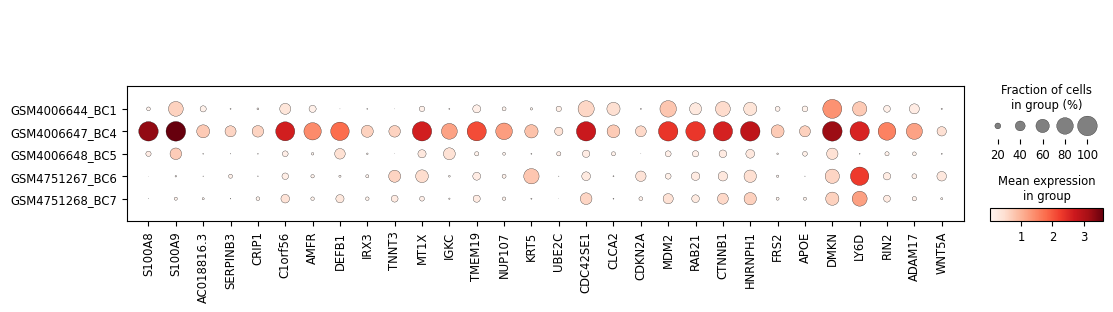

In [46]:
sc.pl.dotplot(adata_log, ['S100A8',
 'S100A9',
 'AC018816.3',
 'SERPINB3',
 'CRIP1',
 'C1orf56',
 'AMFR',
 'DEFB1',
 'IRX3',
 'TNNT3',
 'MT1X',
 'IGKC',
 'TMEM19',
 'NUP107',
 'KRT5',
 'UBE2C',
 'CDC42SE1',
 'CLCA2',
 'CDKN2A',
 'MDM2',
 'RAB21',
 'CTNNB1',
 'HNRNPH1',
 'FRS2',
 'APOE',
 'DMKN',
 'LY6D',
 'RIN2',
 'ADAM17',
 'WNT5A'],groupby='source')